# Notebook Introduction
Within this notebook I will be attempting to analyze a dataset storing a multitude of companies quarterly earning release dates, dividend declaration dates, and dividend expiration dates in order to understand the general flow of companies financial releases. The typical expected pattern is Quarter End Date, followed by an Earnings Declaration, followed by an Earnings Announcement, followed by a Dividend Declaration, followed by a Dividend Expiration. Understanding how exactly this release schedule works and the expected time between announcements is crucial to options trading as earning announcements lead to a massive increase of market volatility, by analyzing past data i hope to gain a deeper understanding of when to expect increased market volatility in the future.

In [239]:
# necessary import statements 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.stats import norm

# Step One: Building and Cleaning the Data
Before we proceed to analyze and make predictions from our dataset we must clean our dataset to our liking. This will consist of multiple key steps:
* Importing our dataset and getting a general feel for the information it stores. Looking at how it stores it by checking its statistics, as well as its datatypes
* Combining earning declarations columns by choosing an appropriate value from "EarningsDeclarationDate" or "EarningsDeclarationDateWSH"
* Marking each datapoint with its appropriate fiscal quarter (as we may want to track differences between announcements in each quarter)
* Removing remaining null data
We begin by importing our data from a csv file to a pandas dataframe and taking a look at its general statistics and datatypes 

In [240]:
# We begin by converting our dataset from a csv file to a pandas dataframe, and looking at its contents
dataset_name = "caseStudyDivErnData.csv"
company_financial_releases_df = pd.read_csv(dataset_name)
company_financial_releases_df.head()



,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsDeclarationDateWSH,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
0,EW,2016,3/31/2016,3/31/2016,3/31/2016,4/26/2016,(null),(null)
1,EW,2016,6/30/2016,7/8/2016,7/8/2016,7/26/2016,(null),(null)
2,EW,2016,9/30/2016,10/5/2016,10/4/2016,10/25/2016,(null),(null)
3,EW,2016,12/31/2016,1/4/2017,1/3/2017,2/1/2017,(null),(null)
4,EW,2017,3/31/2017,4/7/2017,4/6/2017,4/25/2017,(null),(null)


Our dataset consists of company publication release data showing quarterly reports of what dates companies have released their earnings declarations, earnings announcements, dividend declarations, and dividend expirations. Let's try to assertain the size of our dataset, the timeframe it tracks, and the amount of companies it tracks. Before we get started on that however, lets make sure our datatypes are pandas datetime objects to allow for easier and quicker parsing.

In [241]:
company_financial_releases_df.dtypes

USym                          object
FiscalYear                     int64
QuarterEndDate                object
EarningsDeclarationDate       object
EarningsDeclarationDateWSH    object
EarningsAnnouncementDate      object
DividendDeclarationDate       object
DividendExDate                object
dtype: object

Our datatypes are not pandas datetimes but are simply general objects (likely strings, which is to be expected). Lets take a second and convert them, by first converting any null data into None's and then converting dates using pandas built in to_datetime function.

In [242]:
# convert empty values to nulls
replacement = {'(null)' : None}
for col in company_financial_releases_df.columns:
    company_financial_releases_df[col] = company_financial_releases_df[col].replace(replacement)


#convert dates to datetime objects
for i in range(2, company_financial_releases_df.shape[1]):
    col = company_financial_releases_df.columns[i]
    company_financial_releases_df[col] = pd.to_datetime(company_financial_releases_df[col])

# print out new datatypes to verify conversions worked
company_financial_releases_df.dtypes



USym                                  object
FiscalYear                             int64
QuarterEndDate                datetime64[ns]
EarningsDeclarationDate       datetime64[ns]
EarningsDeclarationDateWSH    datetime64[ns]
EarningsAnnouncementDate      datetime64[ns]
DividendDeclarationDate       datetime64[ns]
DividendExDate                datetime64[ns]
dtype: object

Fantastic! Our conversions worked, now lets take a peek at the data inside.

In [243]:
num_entries = company_financial_releases_df.shape[0]
num_companies = len(company_financial_releases_df['USym'].unique())
first_year = company_financial_releases_df['FiscalYear'].min()
final_year = company_financial_releases_df['FiscalYear'].max()
first_quarter = company_financial_releases_df['QuarterEndDate'].min()
final_quarter = company_financial_releases_df['QuarterEndDate'].max()
print(f"number of datapoints: {num_entries}")
print(f"number of companies tracked in dataset: {num_companies}")
print(f"years tracked: {first_year} to {final_year}")
print(f"quarters tracked: {first_quarter} to {final_quarter}")



number of datapoints: 54601
number of companies tracked in dataset: 2102
years tracked: 2015 to 2025
quarters tracked: 2015-11-30 00:00:00 to 2024-09-30 00:00:00


Our dataset contains 54601 datapoints each of which consists of the dates of important financial releases for a single company over a single quarter. In total the dataset contains the data of 2102 companies release dates, spanning from the fiscal years of 2015-2025 going over Q4 2015 to Q3 2024. The final quarter in the dataset looks like it hasn't finished yet however, that's bizzare. In addition to this it seems like the dataset somehow tracks data from the 2025 fiscal year which is yet to occur.  Let's take a look at what's going on there by filtering our dataframe to only look at quarters which have not been compeleted, and then by filtering to look only at the 2025 fiscal year.

In [244]:
current_time = datetime.now()
current_quarter_df = company_financial_releases_df[company_financial_releases_df['QuarterEndDate'] > current_time]
current_quarter_df.head()

,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsDeclarationDateWSH,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
65,HSBC,2024,2024-06-30,2024-05-01,2024-05-01,2024-07-31,NaT,NaT
565,APH,2024,2024-06-30,2024-04-25,2024-04-25,2024-07-24,NaT,NaT
802,AMAT,2024,2024-07-28,2024-05-17,2024-05-17,2024-08-15,NaT,NaT
1101,T,2024,2024-06-30,2024-05-23,2024-05-23,2024-07-24,NaT,NaT
1202,ALV,2024,2024-06-30,2024-04-29,2024-04-28,2024-07-19,NaT,NaT


It looks like this contains partial data on the current quarter which has been collected as some companies have already set the dates on which their earnings declarations and announcements will take place. This makes sense and will likely be useful so we can keep it and deal with the null values when we clean up the rest of the data. Now let's take a look at what's going on with the data from 2025.

In [245]:
future_fiscal_year_df = company_financial_releases_df[company_financial_releases_df['FiscalYear'] == 2025]
future_fiscal_year_df.head()

,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsDeclarationDateWSH,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
1645,BBY,2025,2024-05-04,2024-04-30,2024-04-30,2024-05-30,NaT,NaT
2127,STZ,2025,2024-05-31,2024-06-03,2024-06-03,2024-07-03,NaT,NaT
4319,EA,2025,2024-06-30,2024-05-08,2024-05-08,2024-07-30,NaT,NaT
5481,GCO,2025,2024-05-04,2024-05-10,2024-05-10,2024-05-31,NaT,NaT
5830,GES,2025,2024-05-04,2024-05-24,2024-05-24,2024-05-30,NaT,NaT


It looks like what's going on is differences in the dates companies elect to start their fiscal years on. Although most corporations start their fiscal years on January 1st there is nothing stopping them from picking any other date to base their yearly projections and quarters around, this is an arbitrary decision and  based on the information provided there is no way to assertain what quarter each datapoint refers to. (As we are not given any information on the quarter number nor can we perform any analysis to identify the quarter number that corresponds to the correct end date for all quarter end dates in the dataset.) Due to this, we will set all fiscal years to begin on January 1st, thus allowing for easier data analysis. We will also then do the same for assigning each row a corresponding quarter. As we have not been given the corresponding quarter number for any of our datapoints we will assume Q1 takes up the first three months of the year Q2 the next three, and continue the pattern for Q3 and Q4, once again in order to allow us to parse the data more efficiently and more meaningfully

In [246]:
def standardize_year(date_in):
    try:
        output = date_in.year
    except:
        output = np.nan
    return output

In [247]:
def create_quarter(date_in):
    try:
        if(date_in.month <=3):
            output = 'Q1'
        elif(date_in.month <= 6):
            output = 'Q2'
        elif(date_in.month <= 9):
            output = 'Q3'
        else:
            output = 'Q4'
    except:
        output = None
    return output

In [252]:
company_financial_releases_df['FiscalYear'] = company_financial_releases_df['QuarterEndDate'].apply(standardize_year)
company_financial_releases_df['FiscalYear'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2015],
      dtype=int64)

We now no longer have any maligned data where the fiscal year doesn't match the actual year, now let's add quarter numbers to all datapoints

In [253]:
company_financial_releases_df['Quarter'] = company_financial_releases_df['QuarterEndDate'].apply(create_quarter)
company_financial_releases_df['Quarter'].unique()

array(['Q1', 'Q2', 'Q3', 'Q4'], dtype=object)

Now that we have our data in the correct format, and understand what exactly its stored lets merge the EarningsDeclarationDate columns, taking the values from EarningsDeclarationDate when they exist, and storing the value in EarningsDeclarationDateWSH otherwise.

In [254]:
# merging declaration data together
earning_dec_src_one = company_financial_releases_df['EarningsDeclarationDate']
earning_dec_src_two = company_financial_releases_df['EarningsDeclarationDateWSH']
company_financial_releases_df['EarningsDeclarationDate'] = earning_dec_src_one.combine_first(earning_dec_src_two)
# getting rid of newly unnecessary WSH column
new_company_financial_releases_df = company_financial_releases_df.drop(columns=['EarningsDeclarationDateWSH'])




Now that we have gotten rid of the unnecessary WSH column all of our data is in the expected format. So lets split it up into two dataframes, one tracking dividends and one tracking earning so that we can use earnings data for companies who didn't offer dividends for a quarter in our analysis of Earnings Declaration Dates, while still making to sure to get rid of companies without dividend reports when analyzing Dividend Expirations.

In [255]:
#constructing dataframe to store solely company earnings information
earnings_cols = ['USym', 'FiscalYear', 'QuarterEndDate', 'EarningsDeclarationDate', 'EarningsAnnouncementDate', 'Quarter']
company_earnings_df = new_company_financial_releases_df[earnings_cols]


Now that we have both of our dataframes set up let's try and see if there remains any null data, and if so decide what to do with it.

In [256]:
# grabbing null data
null_earnings = company_earnings_df.isnull().any(axis=1).sum()
num_datapoints = company_earnings_df.shape[0]
null_dividends = company_financial_releases_df.isnull().any(axis=1).sum()

print(f"there is a total of {null_earnings} rows where there exists missing Earnings data, out of a total of {num_datapoints} rows")
print(f"there is a total of {null_dividends} rows where there exists missing dividend data, out of a total of {num_datapoints} rows")

there is a total of 0 rows where there exists missing Earnings data, out of a total of 54601 rows
there is a total of 25199 rows where there exists missing dividend data, out of a total of 54601 rows


It looks like all of our earnings data is present but nearly half of the reports are missing some sort of dividend data- lets check and see if this is because there is some sort of data corruption, or if its just because these companies didn't release dividend reports/pay dividends. We can do this by assuming that if both dividend columns are missing the company didn't release dividends for the quarter, but if only one column of dividend data is present we assume the data has been somehow lost.

In [257]:
dividend_dec_col = new_company_financial_releases_df['DividendDeclarationDate']
dividend_ex_col = new_company_financial_releases_df['DividendExDate']

corrupted_earnings_df = new_company_financial_releases_df[(pd.isnull(dividend_dec_col) & pd.notnull(dividend_ex_col)) | (pd.isnull(dividend_ex_col) & pd.notnull(dividend_dec_col))]
corrupted_earnings_df.head()



,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate,Quarter
48,HSBC,2020,2020-03-31,2020-02-19,2020-04-28,NaT,2020-08-13,Q1
49,HSBC,2020,2020-06-30,2020-04-29,2020-08-03,NaT,2020-08-13,Q2
117,ANF,2020,2020-05-02,2020-05-18,2020-05-28,NaT,2020-09-04,Q2
118,ANF,2020,2020-08-01,2020-07-31,2020-08-27,NaT,2020-09-04,Q3
316,AGCO,2021,2021-03-31,2021-04-06,2021-04-29,NaT,2021-05-07,Q1


In [258]:
corrupted_earnings_df['DividendDeclarationDate'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]

In [259]:
corrupted_earnings_df.describe()

,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
count,2142.000000,2142,2142,2142,0,2142
mean,2019.266106,2019-11-09 20:57:08.571428352,2019-11-25 02:41:20.672268800,2019-12-18 02:02:21.176470528,NaT,2020-10-12 11:28:24.201680384
min,2015.000000,2015-12-26 00:00:00,2016-01-04 00:00:00,2016-01-26 00:00:00,NaT,2016-01-06 00:00:00
25%,2017.000000,2017-12-31 00:00:00,2018-01-24 00:00:00,2018-02-12 00:00:00,NaT,2018-12-16 18:00:00
50%,2019.500000,2020-01-15 12:00:00,2020-02-13 12:00:00,2020-03-12 00:00:00,NaT,2020-09-03 00:00:00
75%,2021.000000,2021-06-30 00:00:00,2021-07-28 00:00:00,2021-08-12 00:00:00,NaT,2023-01-24 00:00:00
max,2024.000000,2024-03-31 00:00:00,2024-05-10 00:00:00,2024-05-28 00:00:00,NaT,2024-06-10 00:00:00
std,2.239128,NaN,NaN,NaN,NaN,NaN


It looks like there are about 2000 corrupted datapoints, all of which have dividend expiration dates but no dividend declaration dates.Because companies must declare dividends in order for them to expire we can assume that this is an issue with our dataset and not some extraneous factor. Because of this we must drop all of these datapoints as it is essential to know the dividend declaration date for us to make any meaningful insights. We also should drop the remaining 18,000 datapoints which don't include dividend information at all as we can assume those companies simply didn't offer any dividends those quarters

In [260]:
cleaned_dividend_df = new_company_financial_releases_df.dropna()

# Step Two: Earnings Analysis
Now that we have our two cleaned dataframes storing dividend and earnings information from the past 10 years, we proceed to try and make the following inferences in our earnings analysis:
* What is the general distribution of the amount of days between a quarter end date and an earnings announcement?
* What effect does the financial quarter (Q1, Q2, Q3, Q4) have on the distribution of the number of days between a quarter end date and an earnings announcement?

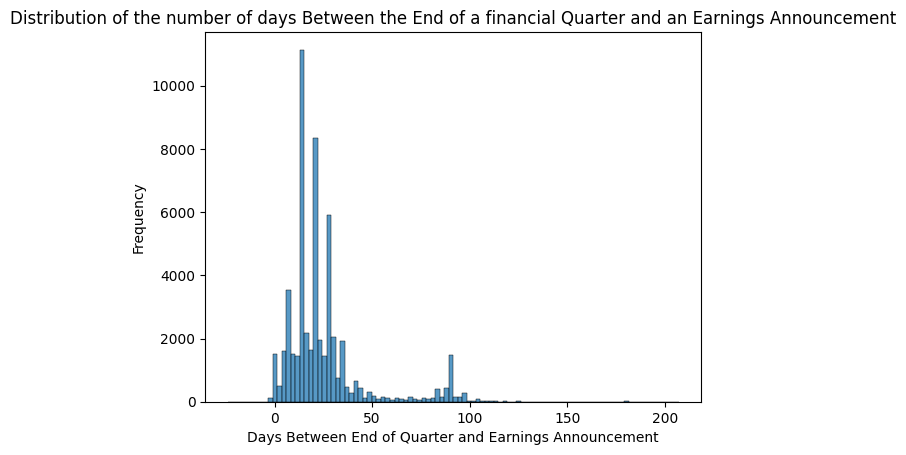

In [281]:
# calculation of number of days between end of quarter and earnings announcement 
company_earnings_df.loc[:,'DaysBetweenQuarterAndAnnouncement'] = (
    company_earnings_df['EarningsAnnouncementDate'] - company_earnings_df['EarningsDeclarationDate']
).dt.days

# histogram displaying distribution of days between end of quarter and earnings declaration
num_bins = 100
sns.histplot(data=company_earnings_df, x="DaysBetweenQuarterAndAnnouncement", bins=num_bins)
plt.xlabel("Days Between End of Quarter and Earnings Announcement")
plt.ylabel("Frequency")
plt.title("Distribution of the number of days Between the End of a financial Quarter and an Earnings Announcement")
plt.show()

We can see from this histogram that the distribution follows a normal distribution pretty uniformly peaking at roughly 29 days after the end of the quarter. Let's take a more in depth look at this by generating a normal distribution.

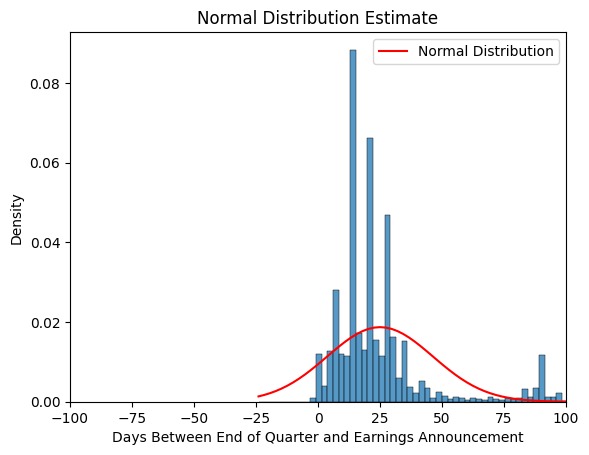

estimated mean and standard deviation for amount of days between the end of a quarter and an earnings declaration, Mean:25.004999908426587 std dev: 21.313853701661802


In [262]:
from scipy.stats import norm
#Histogram displaying normal distribution estimate of data
sns.histplot(data=company_earnings_df, x='DaysBetweenQuarterAndAnnouncement', stat='density', bins=num_bins)

#calculating mean, std and generating a distribution
mean = company_earnings_df['DaysBetweenQuarterAndAnnouncement'].mean()
std_dev = company_earnings_df['DaysBetweenQuarterAndAnnouncement'].std()
x = np.linspace(company_earnings_df['DaysBetweenQuarterAndAnnouncement'].min(), company_earnings_df['DaysBetweenQuarterAndAnnouncement'].max(), 100)


# overlay normal distribution
plt.plot(x, norm.pdf(x, mean, std_dev), label="Normal Distribution", color="red")
plt.xlabel("Days Between End of Quarter and Earnings Announcement")
plt.ylabel("Density")
plt.xlim(-100,100)
plt.title("Normal Distribution Estimate")
plt.legend()
plt.show()

print(f"estimated mean and standard deviation for amount of days between the end of a quarter and an earnings declaration, Mean:{mean} std dev: {std_dev}")

We see from this that 50% of declarations occur within 25 days of the end of a fiscal quarter but we also see a large standard deviation meaning the data is spread out more widely then we'd expect. This is likely due to the hump seen in the right side of the graph showing that a non negligable portion of declarations actually occur between 75-100 days after the end of a quarter, a suprising result as we expect most companies to announce their earnings quickly after the end of a quarter. Let's try and assertain why exactly this hump exists: is there a group of companies that tend to file late? Or a time period/quarter where companies file later then expected?

In [263]:
# grab the subset of declarations occuring over 75 days after the end of the quarter 
late_announcements_df = company_earnings_df[company_earnings_df['DaysBetweenQuarterAndAnnouncement'] > 75]
late_announcement_ratio = (late_announcements_df['USym'].nunique()) / (company_earnings_df['USym'].nunique())
print(f"percentage of companies in database who have filed late at least once: {late_announcement_ratio}")

percentage of companies in database who have filed late at least once: 0.16127497621313036


It looks like a larger amount of companies then expected have declared earnings late, with over 16% of total companies in the dataset declaring their earnings over 75 days after the quarter ends at least once, so this isn't a practice that a couple outlier companies have. Let's try and see if it had something to do with any of the economic downturns over the past 10 years by seeing in which years these early declarations were the most common.

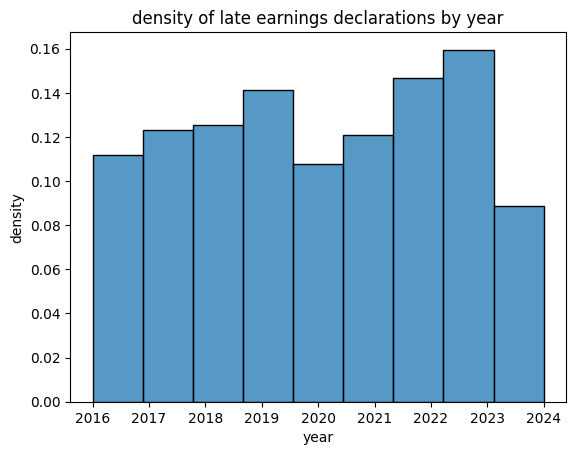

In [264]:
# plotting late earnings declarations by year
num_bins = 9
sns.histplot(data=late_announcements_df, x="FiscalYear", bins=num_bins, stat="density")
plt.xlabel("year")
plt.ylabel("density")
plt.title("density of late earnings declarations by year")
plt.show()

There doesn't seem to be much variation in early earnings declarations by year, as every year has at least 10% of the late announcements, (except for 2024 which is on track to reach 10%). In fact, the years with the most volatility and economic downturn (2020, 2021 due to the covid pandemic) seem to have the least amount of late announcements, lets check if late declarations occur more in specific quarters.

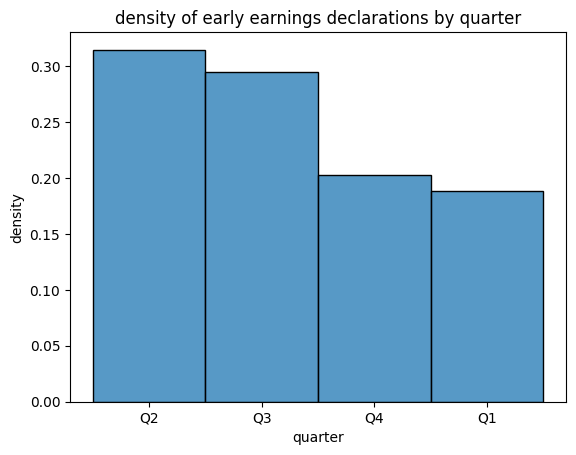

In [265]:
num_bins = 4
sns.histplot(data=late_announcements_df, x="Quarter", bins=num_bins, stat='density')
plt.xlabel('quarter')
plt.ylabel('density')
plt.title('density of early earnings declarations by quarter')
plt.show()


there seems to be some correlation here as Q2, Q3 have nearly double the amount of late announcements as Q4, and Q1 lets break this down further by mapping out these distributions seperatly.

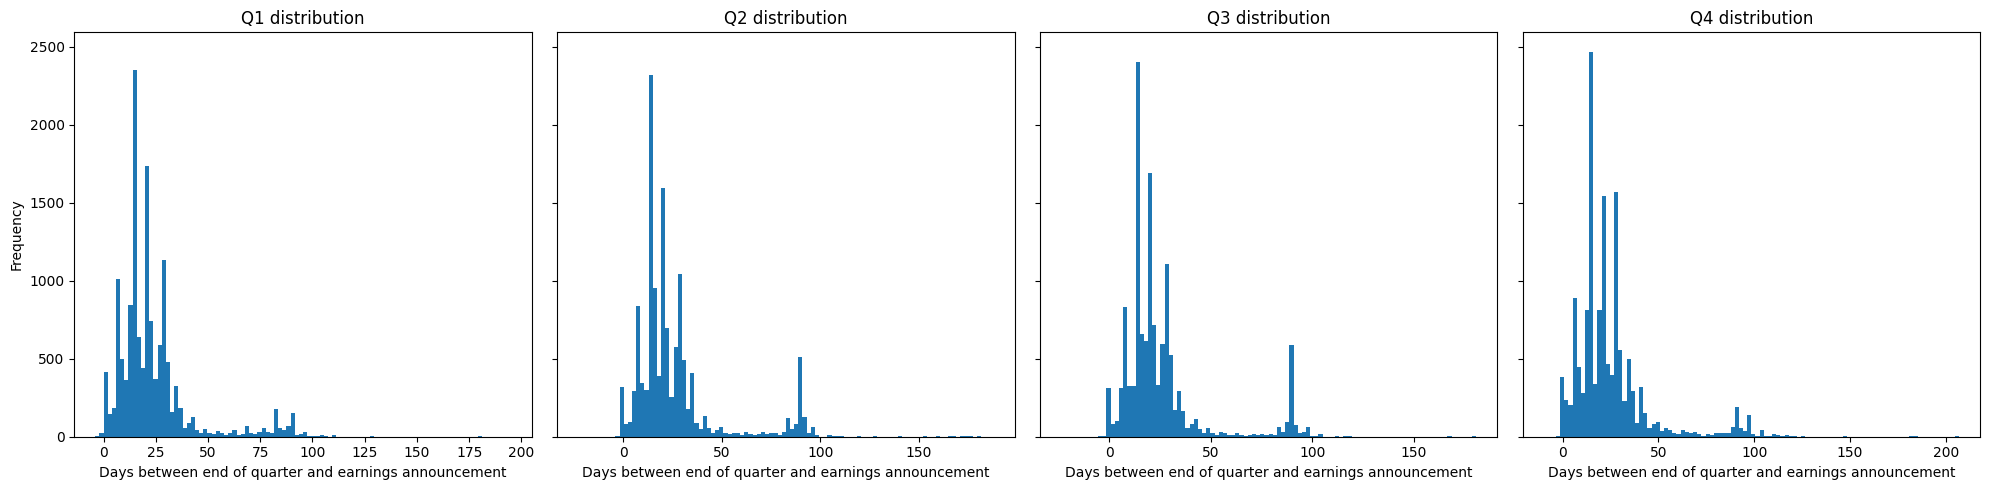

In [266]:
num_bins = 100
# creating figures and subplots showcasing how the time in between quarter end date and earnings declaration changes depending on the given quarter
quarters = company_earnings_df['Quarter'].unique()
fig, axs = plt.subplots(1, len(quarters), figsize=(20,5), sharey=True) # setting sharey ensures all figures have the same timescale on the bottom
for i, quarter in enumerate(quarters): # looping over all quarters to display their plots
    quarter_df = company_earnings_df[company_earnings_df['Quarter'] == quarter]
    axs[i].hist(quarter_df['DaysBetweenQuarterAndAnnouncement'], bins=num_bins)
    axs[i].set_title(f'{quarter} distribution')
    axs[i].set_xlabel('Days between end of quarter and earnings announcement')
    if i == 0:
        axs[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

the plots above show large spikes in both quarter 2 and 3 around the 80-90 day mark and a large increase in announcements around this time compared to the previous 40 days. we can see that much smaller spikes are seen in Q1 and Q4 but these could be easily chalked up to not having a robust and large enough dataset. The spikes in Q2/Q3 suggest there are other factors at play during these quarters that delay companies from announcing their earnings long unti after the quarter ends. Lets attempt to see if this causes a positive correlation between quarter number, and the amount of days between the end of a quarter and an earnings announcement

In [267]:
# dropping unnecessary columns 
quarter_correlation_df = company_earnings_df.loc[:,['DaysBetweenQuarterAndAnnouncement', 'Quarter']]
# converting quarter column to integer
mapping = { 'Q1': 1, 'Q2' : 2, 'Q3' : 3, 'Q4' : 4}
quarter_correlation_df['Quarter'] = quarter_correlation_df['Quarter'].map(mapping)
correlation_matrix = quarter_correlation_df.corr(method="spearman")
print(correlation_matrix['DaysBetweenQuarterAndAnnouncement'])




DaysBetweenQuarterAndAnnouncement    1.00000
Quarter                              0.03998
Name: DaysBetweenQuarterAndAnnouncement, dtype: float64


the correlation coefficiant is around 0.04 suggesting little to no correlation between the quarter in which earnings are declared, and the time from the quarter end date to the earnings declaration. However we can definetly state that if an earnings announcement is more then 50 days following the end of the quarter it is most likely from Q2, or Q3 which could be due to verying market conditions, or an increase in internal, or governmental audits during these times or a multitude of other factors.

# Step Three: Dividend analysis
Now that we have analyzed earnings announcements it is time to look at dividend expiration dates. We will follow similar strategies used above and attempt to parse the distribution of the number of days in between a dividend's declaration and its expiration, as well as the distribution of the number of days in between an earnings announcement and a dividend's expiration in an attempt to discern any patterns we can.

In [282]:
# calculating the number of days between all dividend declaration and dividend expirations
cleaned_dividend_df.loc[:,'DaysBetweenDivDecAndEx'] = (
    cleaned_dividend_df['DividendExDate'] - cleaned_dividend_df['DividendDeclarationDate']
).dt.days
# taking a look at the general statistics
cleaned_dividend_df['DaysBetweenDivDecAndEx'].describe()

count    27030.000000
mean        25.751535
std         17.121542
min          0.000000
25%         13.000000
50%         20.000000
75%         35.000000
max         99.000000
Name: DaysBetweenDivDecAndEx, dtype: float64

We can see from the general statistics that the average time in between a dividend's declaration and its expiration is between 13-36 days, but we also see a couple strange outliers, somehow there are dividends that expire before their declaration, and dividends that expire after more then an entire new quarter lets plot the distribution to get a more general sense of what is going on.

Text(0.5, 1.0, 'distribution of days between dividend declaration and expiration')

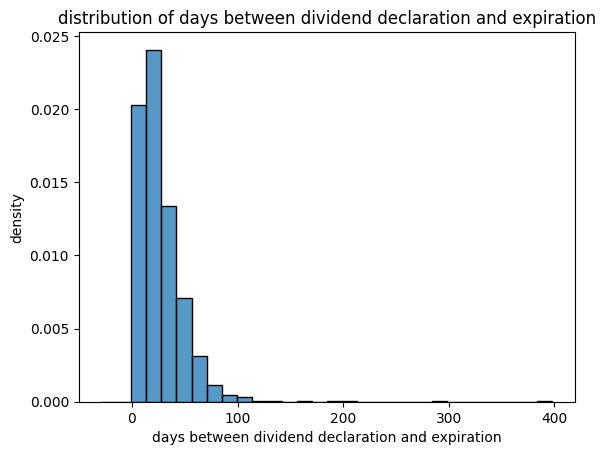

In [269]:
# plotting distribution of days between dividend declaration and expiration
num_bins = 30
sns.histplot(data=cleaned_dividend_df, x='DaysBetweenDivDecAndEx', bins=num_bins, stat="density")
plt.xlabel('days between dividend declaration and expiration')
plt.ylabel('density')
plt.title('distribution of days between dividend declaration and expiration')

suprisingly, we see that the data here is not normally distributed, as the histogram skews to the left heavily, let's take a look at outlier variables and replot the distribution to see if anything changes, from our analysis above it seems like there are outlier some dividends with expirations before their declarations, or with exparations over a quarter away, lets see if we can remove those 

In [270]:
invalid_dividends_df = cleaned_dividend_df[(cleaned_dividend_df['DaysBetweenDivDecAndEx'] < 0) | (cleaned_dividend_df['DaysBetweenDivDecAndEx'] >= 100)]
num_invalid_dividends = invalid_dividends_df.shape[0]
print(f"there are {num_invalid_dividends} with expiration dates earlier then their declaration or with expirations past an entire year")

there are 276 with expiration dates earlier then their declaration or with expirations past an entire year


as there are only 260 cases of expiration dates earlier then declaration, or expiration over a year later out of more then 20,000 cases. lets remove them from the dataset as insignificant outliers, and take another look at the general statistics

In [271]:
cleaned_dividend_df = cleaned_dividend_df[(cleaned_dividend_df['DaysBetweenDivDecAndEx'] >= 0) & (cleaned_dividend_df['DaysBetweenDivDecAndEx'] < 100)]
cleaned_dividend_df['DaysBetweenDivDecAndEx'].describe()

count    29265.000000
mean        25.782436
std         17.275710
min          0.000000
25%         13.000000
50%         20.000000
75%         35.000000
max         99.000000
Name: DaysBetweenDivDecAndEx, dtype: float64

This has had a significant impact on the standard deviation as well as the mean, lets replot the data and take another look at it to see if anything has changed

Text(0.5, 1.0, 'distribution of days between dividend declaration and expiration')

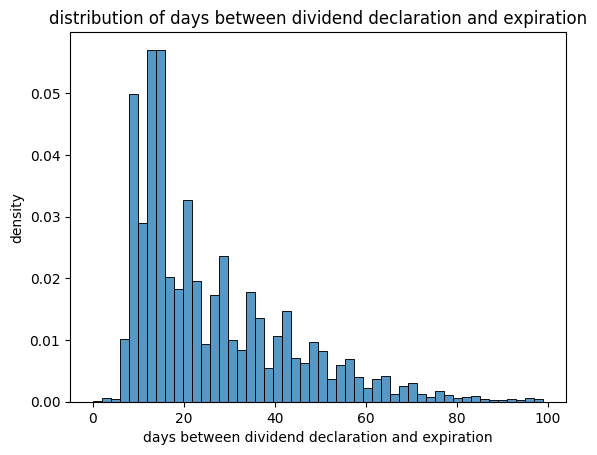

In [272]:
# plotting distribution of days between dividend declaration and expiration
num_bins = 50
sns.histplot(data=cleaned_dividend_df, x='DaysBetweenDivDecAndEx', bins=num_bins, stat="density")
plt.xlabel('days between dividend declaration and expiration')
plt.ylabel('density')
plt.title('distribution of days between dividend declaration and expiration')

The data remains unevenly distributed with a strong left skew, this tells us that most companies are incentivized to have their dividends expire shortly after their declaration, and can expect most dividends to expire within 10-20 days of their declaration. In order to confirm this trend has generalization lets take a look at the distributions of each quarter seperatly

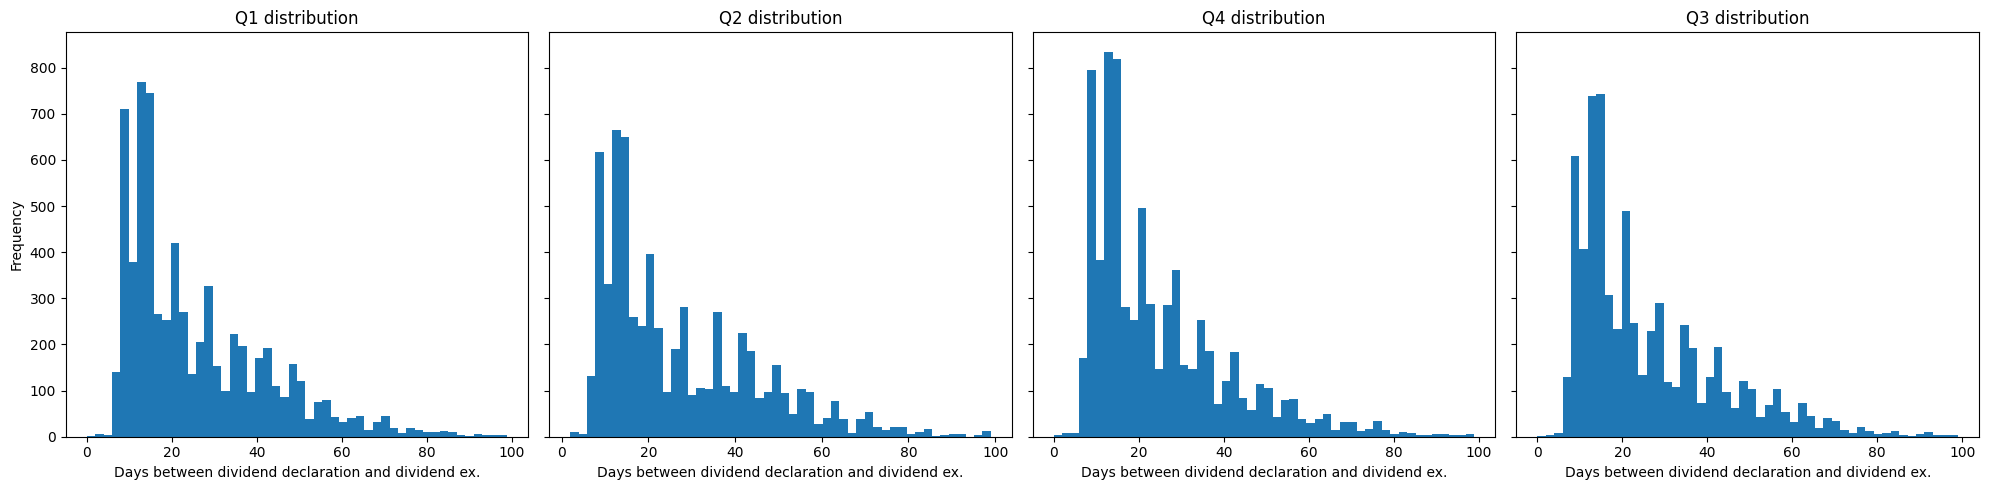

In [283]:
num_bins = 50
# creating figures and subplots showcasing how the time in between quarter end date and earnings declaration changes depending on the given quarter
quarters = cleaned_dividend_df['Quarter'].unique()
fig, axs = plt.subplots(1, len(quarters), figsize=(20,5), sharey=True) # setting sharey ensures all figures have the same timescale on the bottom
for i, quarter in enumerate(quarters): # looping over all quarters to display their plots
    quarter_df = cleaned_dividend_df[cleaned_dividend_df['Quarter'] == quarter]
    axs[i].hist(quarter_df['DaysBetweenDivDecAndEx'], bins=num_bins)
    axs[i].set_title(f'{quarter} distribution')
    axs[i].set_xlabel('Days between dividend declaration and dividend ex.')
    if i == 0:
        axs[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

this trend does seem to be robust amongst all financial quarters giving us more confidence in our claim that companies are incentivized to reduce the time between dividend declaration and expiration and will likely target between 10-20 days. Lets take a look at the number of days between earnings announcement and dividend expiration to see if this trend holds true

In [274]:
# calculating the number of days between all earnings announcements and dividend expirations
cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] = (
    cleaned_dividend_df['DividendExDate'] - cleaned_dividend_df['EarningsAnnouncementDate']
).dt.days
# taking a look at the general statistics
cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'].describe()

count    29265.000000
mean       101.779839
std        313.379132
min       -386.000000
25%         11.000000
50%         27.000000
75%         49.000000
max       3052.000000
Name: DaysBetweenEarnAnAndDivEx, dtype: float64

we seem to have some massive outliers here, with some dividend expirations occuring over a year before the earnings announcements and some occuring nearly 10 years after, lets clean up these statistical outliers by looking at the amount of dividends that expire an entire quarter after their earnings are announced, or expire before their earnings are announced

In [275]:
outlier_df = cleaned_dividend_df[(cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] < 0) | (cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] >= 100) ]
outlier_num = outlier_df.shape[0]
print(f"there are {outlier_num} outliers in the dataset with dividend Ex.'s before earnings declaration, or over a quarter after")

there are 6990 outliers in the dataset with dividend Ex.'s before earnings declaration, or over a quarter after


In [276]:
outlier_df = cleaned_dividend_df[(cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] < 0)]
outlier_num = outlier_df.shape[0]
print(f"there are {outlier_num} outliers in the dataset with dividend expirations before earnings declaration")

there are 3541 outliers in the dataset with dividend expirations before earnings declaration


After researching dividend Ex. Dates I have found that these outliers might make sense. A dividend Ex. Date refers to the date at which a purchaser of a stock will no longer be eligible to recieve a dividend payment from that quarter's profits on the stock. So some companies in order to incentivize early purchase may set their dividend Ex. Date to before earnings are announced, and others to retain stock value may set the dividend Ex. Date far past the earnings announcement. The extreme outliers however, of over a quarter in the past, or three quarters in the future, are likely clerical errors and can be wiped in order to preserve the general statistics of the dataset

In [277]:
outlier_df = cleaned_dividend_df[(cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] < - 100) | (cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] > 270)]
outlier_num = outlier_df.shape[0]
print(f"there are {outlier_num} outliers in the dataset with dividend Ex.'s over a quarter before earnings declaration, or three quarters following")

there are 2235 outliers in the dataset with dividend Ex.'s over a quarter before earnings declaration, or three quarters following


this is a much more reasonable number of outliers, amounting to roughly 7% of the data, lets remove them and recalculate the general statistics

In [278]:
cleaned_dividend_df = cleaned_dividend_df[(cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] >= -100) & (cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'] <= 270)]
cleaned_dividend_df['DaysBetweenEarnAnAndDivEx'].describe()

count    27030.000000
mean        29.367148
std         39.211237
min        -99.000000
25%         10.000000
50%         23.000000
75%         42.000000
max        270.000000
Name: DaysBetweenEarnAnAndDivEx, dtype: float64

getting rid of these outliers greatly reduced the standard deviation and mean of our dataset and will result in a smoother histogram, lets finally check if the leftward skew seen in the distribution of days between dividend declarations and dividend Ex's is also found in the distribution of days between earnings announcements and dividend Ex's

Text(0.5, 1.0, 'distribution of days between earnings announcement and dividend ex.')

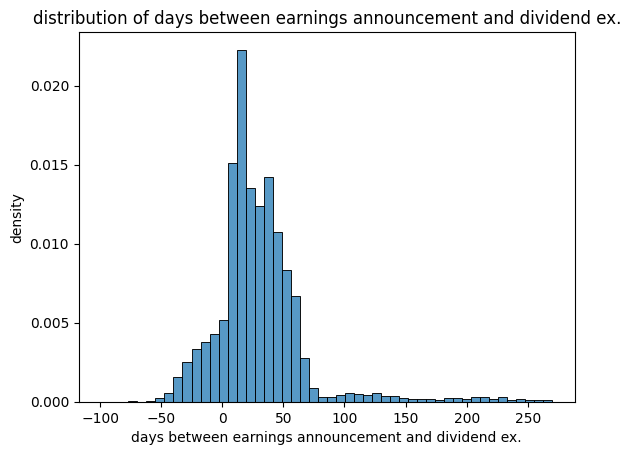

In [279]:
# plotting distribution of days between earnings announcement and dividend ex.
num_bins = 50
sns.histplot(data=cleaned_dividend_df, x='DaysBetweenEarnAnAndDivEx', bins=num_bins, stat="density")
plt.xlabel('days between earnings announcement and dividend ex.')
plt.ylabel('density')
plt.title('distribution of days between earnings announcement and dividend ex.')

the distribution here is more normally distributed but is actually skewed to the right indicating companies are incentivized to give traders time between their earnings announcement and dividend Ex's likely so the stock price can stabalize between the two events. In general however we would expect most companies to set their dividend Ex, dates within 10-50 days following their earnings announcements, with over 50% of dividend Ex. dates occuring between 10 and 42 days, once again, lets see if this trend holds across financial quarters so our findings can be more robust.

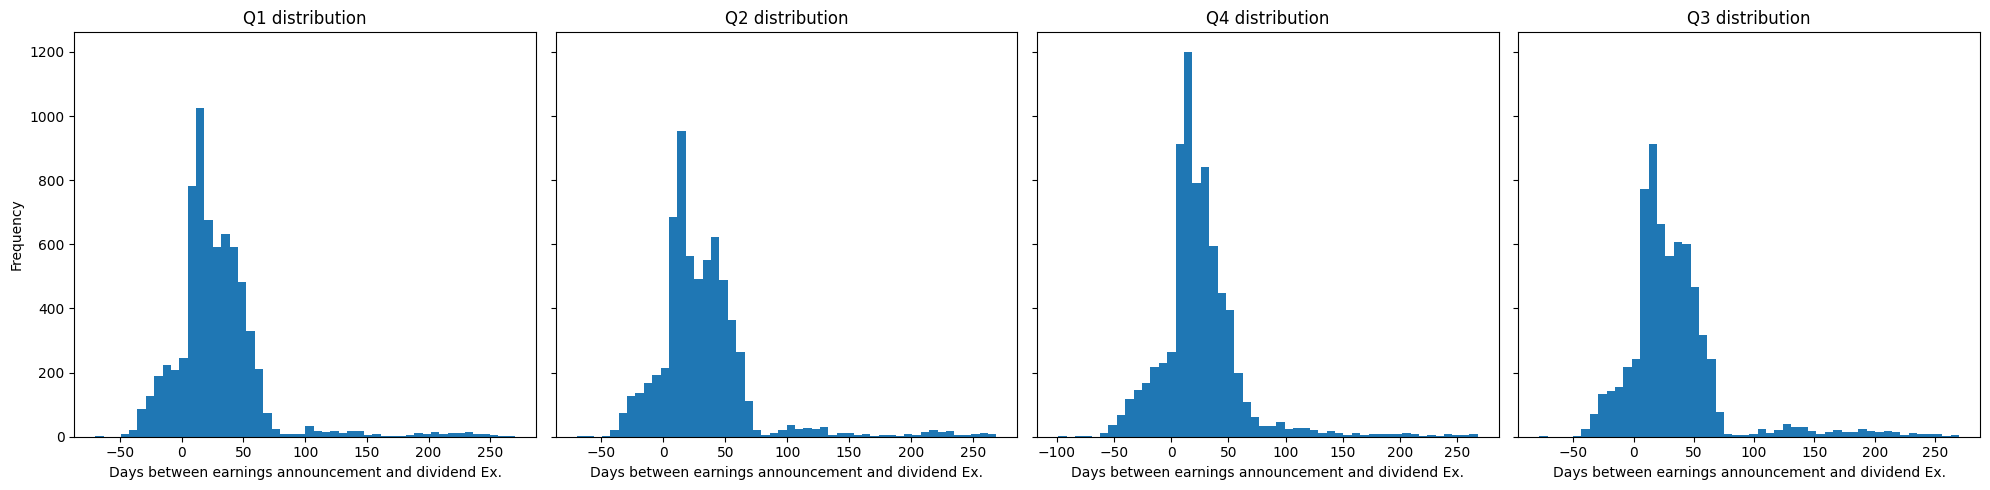

In [284]:
num_bins = 50
# creating figures and subplots showcasing how the time in between quarter end date and earnings declaration changes depending on the given quarter
quarters = cleaned_dividend_df['Quarter'].unique()
fig, axs = plt.subplots(1, len(quarters), figsize=(20,5), sharey=True) # setting sharey ensures all figures have the same timescale on the bottom
for i, quarter in enumerate(quarters): # looping over all quarters to display their plots
    quarter_df = cleaned_dividend_df[cleaned_dividend_df['Quarter'] == quarter]
    axs[i].hist(quarter_df['DaysBetweenEarnAnAndDivEx'], bins=num_bins)
    axs[i].set_title(f'{quarter} distribution')
    axs[i].set_xlabel('Days between earnings announcement and dividend Ex.')
    if i == 0:
        axs[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

this pattern holds across all financial quarters, with Q4 seeing more dividends then other quarters but with the distribution remaining similar. this gives us more confidence in our claim that companies are incentivized to give more time between earnings announcement and dividend ex's, and that most dividend ex's can be expected to occur between 10-50 days following an earnings announcement. 

# Step Four Conclusion/Findings
#### Correlation
although we were unable to establish strong links or correlations between quarter number or fiscal year and dividend Ex. dates or earning announcement dates we did find that their distributions per quarter were much more even then expected with little to no connection between quarter number and time between events, this was a suprising result as we expected to see much more difference in distribution between Q1-3, and Q4 as companies are given additional time to file in Q4, but our findings show that if antyhing  the timing between earnings announcements and dividend ex's in Q4 is lower on average then other quarters and the timing between the end of a quarter and earnings announcements, or between dividend declarations and dividend ex's. Even more suprisingly, we found that the general sequence of Quarter end -> earnings declaration -> earnings announcement -> dividend declaration -> dividend ex to be fickle. The first three steps hold true over 99.9% of the time, however it is not uncommon for companies to declare their dividends after the dividend Ex. date has passed, with this occuring over 20% of the time in our dataset. More studies are likely needed to discover why such is the case.

#### Earnings Announcements
the key inferences we made which may allow for better prediction of timing of earnings announcements where that the timing between the end of the quarter and earnings announcements was largely evenly distributed with a small bump occuring at the beginning of the next financial quarter 75-100 days later. From this we were able to asertain that most earnings announcements will occur between 10-30 days following the end of a quarter, with a standard deviation of roughly 20 days, centered at 20 days following the end of the quarter. Due to the large bump around the 80 day mark we were also able to assertain that if an earnings announcement had not come following 30 days of the end of the quarter it would likely take another 50-70 days before it was released.

#### Dividend Ex. Dates

we found that unlike the time between the end of the quarter and earnings announcements, the time between earning announcements and Div Ex's, and dividend declarations and earning announcements was not normally distributed, with the time between earning announcements and Div Ex's showing strong right skew, and the timing between dividend declarations and dividend ex's showing strong left skew. This would suggest that companies are incentivized to give more time between their earning announcements and dividend declarations to allow for the price of the stock to stabalize, and also seek to keep the time in which people may buy stock, while knowing the dividends they will recieve on the stock as short as possible. Because of these incentives we found that a dividend Ex. Date is likely to occur within 10-50 days following an earnings declaration, and within the 10-30 days following a dividend's declaration. This result is suprising due to the fact that so many dividend Ex. dates occured before earnings announcements and more studies will likely show a strong corelation between dividend Ex. dates occuring before earning announcements, followed by immediate dividend declarations soon after the earning announcements.

#### Future Analysis
Future analysis in the following areas may be promising following the resutls of the analysis in this notebook
* the correlation between dividend Ex's occuring before earnings announcements, and dividend declarations occuring within 5 days following.
* the correlation between earnings announcements occuring rapidly after the end of the quarter, followed by dividend declarations and Ex's occuring at similarly rapid paces
* the correlation between earnings announcements occuring far after the end of the quarter, followed by dividend declarations and ex's occuring at similarly sluggish paces
* the correlatin between the time between the end of the quarter and earnings announcements, or dividend Ex. Dates following positive or negative quarters.
